In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import math
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image
import os, sys, shutil
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split

In [2]:
SATURATION  = (0.9, 1.1)
CONTRAST = (0.9, 1.1)
BRIGHTNESS  =  0.1
ROTATION    = 10.0
SHEAR    = 2.0
HZOOM  = 8.0
WZOOM  = 4.0
HSHIFT = 4.0
WSHIFT = 4.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = cfg.input_dims[0]
    XDIM = DIM%2
    
    rot = ROTATION * tf.random.normal([1], dtype='float32')
    shr = SHEAR * tf.random.normal([1], dtype='float32')
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM
    h_shift = HSHIFT * tf.random.normal([1], dtype='float32')
    w_shift = WSHIFT * tf.random.normal([1], dtype='float32')
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot, shr, h_zoom, w_zoom, h_shift, w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]), label

In [3]:
#!pip install efficientnet -q

In [4]:
import os

#import efficientnet.tfkeras as efn
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
import math

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from PIL import Image

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers


# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#   except RuntimeError as e:
#     print(e)


In [8]:
# To generate GIFs
# ! pip install imageio
# ! pip install git+https://github.com/tensorflow/docs

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [9]:
def seed_everything(SEED):
    os.environ['PYTHONHASHSEED']=str(SEED)
    #random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)

In [10]:
seed_everything(123)

In [70]:
def build_decoder(with_labels=True, target_size=(256, 256), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)

        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_flip_up_down(img)
        img = tf.image.random_saturation(img, SATURATION[0], SATURATION[1])
        img = tf.image.random_contrast(img, CONTRAST[0], CONTRAST[1])
        img = tf.image.random_brightness(img, BRIGHTNESS)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, bsize=128, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024,
                  seed=None, cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
#     dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    
    # Map the functions to perform Augmentations
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.map(transform, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle, seed=seed) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

In [71]:
class Config:
    seed = 123
    job = 1
    num_classes = 25
    input_dims = (256, 256)
    model_arch = "efficientnetv2-l-21k-ft1k" ## Choose model architecture
    batch_size = 32
    kfold = 5
    n_epochs = 15
    lr = 0.001
    loss_func = 'categorical_crossentropy'
    # Whether to finetune the whole model or just the top layer.
    fine_tune = True
    wandb_project = 'SIIM_classifier_public'
    dataset = "siim-covid19-images-metadata-256-512-768"
    
    seed_everything(seed)
    
cfg = Config()

In [72]:
batch_size = 16
img_height = 256
img_width = 256
path = 'data/'

train_dir = path + '/train-calibrated-shuffled.txt'
validation_dir = path + '/val-calibrated-shuffled.txt'
test_dir = path + '/test-calibrated-shuffled.txt'

In [73]:
train_df = pd.read_csv(train_dir, header=None, delimiter = " ")

In [74]:
val_df = pd.read_csv(validation_dir, header=None, delimiter = " ")

In [75]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train_df)
enc.transform(train_df).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
valid_paths = path + train_df[0] 
train_paths = path + val_df[0] 
valid_labels = train_df[1].values
train_labels = val_df[1].values

In [77]:
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [78]:
train_dataset = build_dataset(
    train_paths, labels=None, bsize=cfg.batch_size, decode_fn=decoder
)

ValueError: in user code:

    <ipython-input-11-f54ebd2736ee>:24 augment  *
        img = tf.image.random_flip_left_right(img)
    C:\Users\Home\anaconda3\envs\py36\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    C:\Users\Home\anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\image_ops_impl.py:422 random_flip_left_right
        return _random_flip(image, 1, random_func, 'random_flip_left_right')
    C:\Users\Home\anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\image_ops_impl.py:507 _random_flip
        image = _AssertAtLeast3DImage(image)
    C:\Users\Home\anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\image_ops_impl.py:199 _AssertAtLeast3DImage
        _CheckAtLeast3DImage(image, require_static=False), image)
    C:\Users\Home\anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\image_ops_impl.py:224 _CheckAtLeast3DImage
        image.shape)

    ValueError: 'image' (shape ()) must be at least three-dimensional.


In [61]:
decoder = build_decoder(with_labels=True, target_size=cfg.input_dims, ext='png')
test_decoder = build_decoder(with_labels=False, target_size=cfg.input_dims, ext='png')

import tensorflow.keras.backend as K
train_dataset = build_dataset(
    train_paths, train_labels, bsize=cfg.batch_size, decode_fn=decoder
)

valid_dataset = build_dataset(
    valid_paths, valid_labels, bsize=cfg.batch_size, decode_fn=decoder,
    repeat=False, shuffle=False, augment=False
)

num_classes = cfg.num_classes if cfg.num_classes else train_labels.shape[1]

In [62]:
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>

In [63]:
class_names = []
df = pd.read_csv(path + '/msl_synset_words-indexed.txt', header=None)
for i in df[0]:
    class_names.append(i.split()[1])

In [23]:
'''
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
'''

'\nfor image, label in train_ds.take(1):\n  print("Image shape: ", image.numpy().shape)\n  print("Label: ", label.numpy())\n'

In [24]:
def make_generator_model():
    model = tf.keras.Sequential()
    n_nodes = 256*16*16
    model.add(layers.Dense(n_nodes, use_bias=False, input_shape=(256,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    #assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (3, 3), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

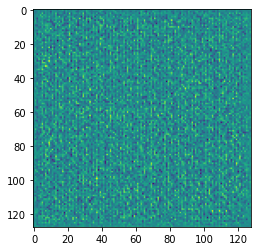

In [25]:
generator = make_generator_model()

noise = tf.random.normal([1, 256])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [26]:
def make_discriminator_model(in_shape=(128,128,3)):
    model = tf.keras.Sequential()
    # input layer with image size of 128x128, since its a colored image it has 3 channels
    model.add(layers.Conv2D(16, (3,3), padding='same', input_shape=in_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 64x64 using strides of 2,2 and use of LeakyReLU
    model.add(layers.Conv2D(8, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(layers.Conv2D(16, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(layers.Conv2D(8, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # now the image size is down to 16 x 16
    # classifier 
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [27]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49953339]], shape=(1, 1), dtype=float32)


In [28]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [32]:
EPOCHS = 5
noise_dim = 256
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [34]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([cfg.batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [35]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [36]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [37]:
train(train_dataset, EPOCHS)

ValueError: in user code:

    <ipython-input-34-b48ef71bbd95>:10 train_step  *
        real_output = discriminator(images, training=True)
    C:\Users\Home\anaconda3\envs\py36\lib\site-packages\keras\engine\base_layer.py:1020 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Home\anaconda3\envs\py36\lib\site-packages\keras\engine\input_spec.py:202 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer sequential_1 expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'images:0' shape=(32, 256, 256, 3) dtype=float32>, <tf.Tensor 'images_1:0' shape=(32,) dtype=int64>]


In [54]:
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>

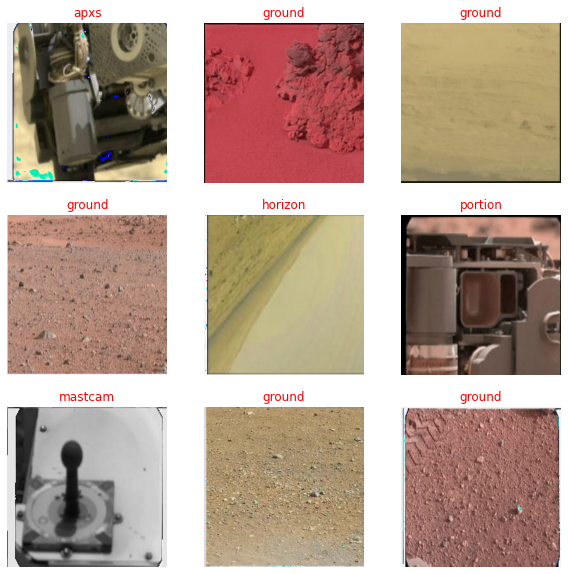

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label], c='r')
  plt.axis("off")

In [ ]:
data_augmentation = tf.keras.Sequential([        
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),                          
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

In [ ]:
model = tf.keras.Sequential([
            efn.EfficientNetB0(
                input_shape=(256, 256, 3),
                weights='imagenet',
                include_top=False),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(25, activation='softmax')
        ])

16809984/16804768 [==============================] - 0s 0us/step


In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)


In [ ]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  4


In [ ]:
len(model.trainable_variables)

213

In [ ]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", patience=3, min_lr=1e-6, mode='min')

In [ ]:
print(1)

1


In [ ]:
history = model.fit(train_ds, epochs= 20, callbacks=lr_reducer, validation_data=val_ds)

Epoch 1/20
118/118 [==============================] - 577s 5s/step - loss: 1.2566 - accuracy: 0.7400 - val_loss: 1.6200 - val_accuracy: 0.5299
Epoch 2/20
118/118 [==============================] - 48s 406ms/step - loss: 0.2530 - accuracy: 0.9445 - val_loss: 0.5881 - val_accuracy: 0.8293
Epoch 3/20
118/118 [==============================] - 47s 399ms/step - loss: 0.1147 - accuracy: 0.9760 - val_loss: 0.3923 - val_accuracy: 0.9195
Epoch 4/20
118/118 [==============================] - 48s 407ms/step - loss: 0.0660 - accuracy: 0.9851 - val_loss: 0.3654 - val_accuracy: 0.9146
Epoch 5/20
118/118 [==============================] - 48s 404ms/step - loss: 0.0407 - accuracy: 0.9912 - val_loss: 0.3712 - val_accuracy: 0.9122
Epoch 6/20
118/118 [==============================] - 47s 402ms/step - loss: 0.0301 - accuracy: 0.9923 - val_loss: 0.3542 - val_accuracy: 0.9128
Epoch 7/20
118/118 [==============================] - 47s 402ms/step - loss: 0.0246 - accuracy: 0.9944 - val_loss: 0.3240 - val_accu

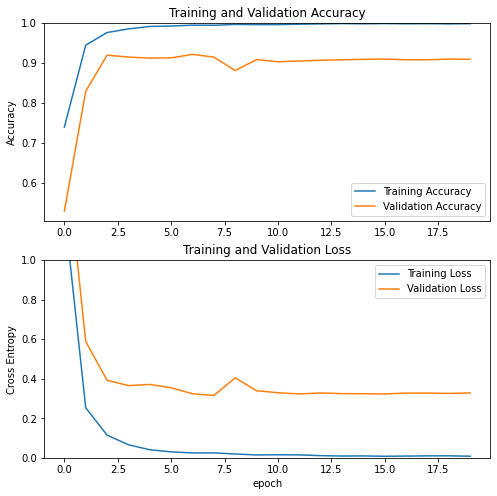

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
train_images = []
train_labels = []
test_images = []
test_labels = []
for i,j in train_ds:
  train_images.append(i)
  train_labels.append(j)
for i,j in val_ds:
  test_images.append(i)
  test_labels.append(j)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_ds)

acc = accuracy_score(test_labels[:52], np.round(preds)[:52])*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['acc'][-1])*100, 2)))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: ignored

In [ ]:
model.predict(test_ds).shape

(1305, 25)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(np.array(test_images[0]))

In [ ]:
model.predict(np.array(test_images[0]))

In [ ]:
model.predict(tf.reshape(test_images[0], [256, 256, 3]))